In [1]:
import os
import numpy as np
import pandas as pd
import bambi
import pymc3 as pm
import arviz as az
from scipy.stats import spearmanr

import seaborn as sns
sns.set_context('paper')
sns.set_style("ticks")

import matplotlib.pyplot as plt
%matplotlib inline

from utils.stats import sem_p, compute_ttests, get_var
from utils.plotting import add_ttest, despine, cm2inch, violin
from utils.general import make_sure_path_exists
from utils.descriptives import compute_gaze_influence_score, compute_p_last_gaze_choice

# Descriptives & data

In [2]:
# directories
data_dir = '../data/'
mfx_dir = '../results/posterior_traces/mixed_effects_models/'
figure_dir = '../figures/'

# make sure output dirs exist
make_sure_path_exists(figure_dir)
make_sure_path_exists(mfx_dir)

# set sizes
setsizes = np.array([9, 16, 25, 36])
# colors for each choice set size
colors = ['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral']

# read response data
data =[]
for setsize in setsizes:
    df_setsize = pd.read_csv(data_dir+'summary_files/{}_data.csv'.format(setsize))
    df_setsize['setsize'] = setsize
    data.append(df_setsize)
data = pd.concat(data, sort=True)

# add RT in seconds
data['rt_s'] = data['rt'].values / 1000.
    
# read out subject IDs
subjects = np.unique(data.subject)
n_subjects = subjects.size
    
# read in gaze data
gaze_data = []
for subject in subjects:
    for c in setsizes:
        tmp_data = pd.read_csv(data_dir+'subject_files/{}_{}_fixations.csv'.format(subject, c))
        tmp_data = tmp_data[[c for c in tmp_data.columns if not 'Unnamed:' in c]]
        gaze_data.append(tmp_data)
gaze_data = pd.concat(gaze_data, sort=True)

In [3]:
data.head()

,best_chosen,best_seen_chosen,choice,fixation_count,fixation_onset_0,fixation_onset_1,fixation_onset_10,fixation_onset_11,fixation_onset_12,fixation_onset_13,...,stimulus_35,stimulus_4,stimulus_5,stimulus_6,stimulus_7,stimulus_8,stimulus_9,subject,trial,rt_s
0,1.0,1.0,1,18.0,1662.0,1238.0,NaN,NaN,NaN,NaN,...,NaN,nr62.png,nr125.png,nr63.png,nr113.png,nr27.png,NaN,0,2,8.468078
1,1.0,1.0,0,14.0,907.0,625.0,NaN,NaN,NaN,NaN,...,NaN,nr76.png,nr93.png,nr79.png,nr4.png,nr92.png,NaN,0,3,4.734945
2,1.0,1.0,1,20.0,893.0,503.0,NaN,NaN,NaN,NaN,...,NaN,nr56.png,nr91.png,nr30.png,nr106.png,nr121.png,NaN,0,7,7.822484
3,1.0,1.0,3,12.0,773.0,4625.0,NaN,NaN,NaN,NaN,...,NaN,nr21.png,nr85.png,nr2.png,nr58.png,nr7.png,NaN,0,9,5.557554
4,1.0,1.0,4,22.0,786.0,1010.0,NaN,NaN,NaN,NaN,...,NaN,nr69.png,nr81.png,nr79.png,nr58.png,nr28.png,NaN,0,14,9.125540


In [4]:
gaze_data.head()

,choice,dur,fixnum,is_first,is_last,is_last_to_choice,is_refixation,item,onset,refixnum,setsize,stimulus,subject,trial,value
0,1,552,1,1.0,0.0,1,0,4,76,0.0,9,nr62.png,0,2,0
1,1,188,2,0.0,0.0,1,0,3,678,0.0,9,nr48.png,0,2,0
2,1,260,3,0.0,0.0,1,0,7,922,0.0,9,nr113.png,0,2,0
3,1,348,4,0.0,0.0,1,0,1,1238,0.0,9,nr10.png,0,2,2
4,1,326,5,0.0,0.0,1,0,0,1662,0.0,9,nr91.png,0,2,0


In [5]:
# compute average number of trials dropped per participant
n_trials_per_subject = data.groupby(['setsize','subject']).size().reset_index(name='counts')
n_trials_per_subject['n_missing_trials'] = (50 - # experiment included 50 trials per set size
                                            n_trials_per_subject['counts'])
mean_missing_trials = n_trials_per_subject.groupby(['subject']).n_missing_trials.mean().mean()
sem_missing_trials = n_trials_per_subject.groupby(['subject']).n_missing_trials.mean().sem()
print('{0:.2f} (SE: {1:.2f}) missing trials per participant per set size condition'.format(
        mean_missing_trials, sem_missing_trials))

4.15 (SE: 0.64) missing trials per participant per set size condition


# Mean RT

In [6]:
rt_means = data.groupby(['setsize','subject']).rt_s.mean().groupby(level=0).mean()
rt_sems = data.groupby(['setsize','subject']).rt_s.mean().groupby(level=0).sem()

In [7]:
# compute t-tests
rt_sub_meas = np.concatenate([data.groupby(['setsize', 'subject']).rt_s.mean()[s][:,None]
                               for s in setsizes], axis=1)
T_rt, df_rt, P_rt = compute_ttests(rt_sub_meas)

/opt/miniconda3/envs/GLAM/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


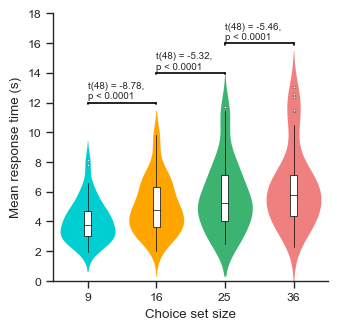

In [8]:
fig, ax = plt.subplots(1,1,figsize=cm2inch(9,9), dpi=100)
ax = violin(data=pd.DataFrame(rt_sub_meas), ax=ax, palette=colors)
add_ttest(ax,
          T_rt, df_rt, P_rt,
          [(0, 1), (1, 2), (2, 3)],
          [(12, 12), (14,14), (16,16)],
          -0.100, 0.25)
ax.set_ylim(0,18)
ax.set_ylabel('Mean response time (s)')
ax.set_xlabel('Choice set size')
ax.set_xticklabels(setsizes)
despine(ax=ax)

## MFX: $RT \sim setsize$

In [9]:
np.random.seed(1678)
mfx_filename = 'rt_setsize_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    model = bambi.Model(data=data)
    model.add('rt ~ setsize', random=['setsize|subject'], categorical=['subject'])
    
    # sample posterior
    results = model.fit(samples=samples, 
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000,
                        random_seed=1678)

    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
            
else:
    print('Loading mfx-summary from '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'setsize[0]')

Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 3471.428784979065, 94% HPD: 3086.167479771974, 3834.2464491068986
setsize[0]; Mean: 84.78048441671038, 94% HPD: 67.29167748588331, 102.28978782935144


# P(best seen item chosen)

In [10]:
best_seen_chosen_means = data.groupby(
    ['setsize', 'subject']).best_seen_chosen.mean().groupby(level=0).mean()
best_seen_chosen_sems = sem_p(data.groupby(
    ['setsize','subject']).best_seen_chosen.mean().groupby(level=0).mean().values, n_subjects)

In [11]:
# compute t-tests
sub_best_seen_chosen_means = np.concatenate(
    [np.array(data.groupby(['setsize', 'subject']).best_seen_chosen.mean()[s])[:,None]
     for s in setsizes], axis=1)
(T_best_seen_chosen,
 df_best_seen_chosen,
 P_best_seen_chosen) = compute_ttests(sub_best_seen_chosen_means)

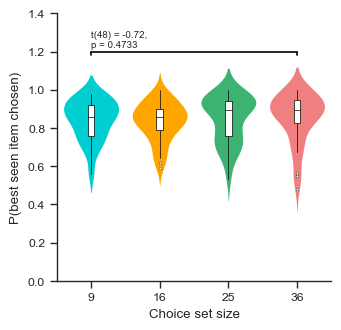

In [12]:
fig, ax = plt.subplots(1,1,figsize=cm2inch(9,9), dpi=100)
ax = violin(data=pd.DataFrame(sub_best_seen_chosen_means), ax=ax, palette=colors)
add_ttest(ax,
          [T_best_seen_chosen[-1]], df_best_seen_chosen, [P_best_seen_chosen[-1]],
          [(0, 3)],
          [(1.2, 1.2)],
          -.02, .02)
ax.set_ylim(0, 1.4)
ax.set_ylabel('P(best seen item chosen)')
ax.set_xlabel('Choice set size')
ax.set_xticklabels(setsizes)
despine(ax=ax)

## MFX: $P(best\_seen\_chosen) \sim setsize$

In [13]:
np.random.seed(1523)
mfx_filename = 'p-choose-best-seen_setsize_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    model = bambi.Model(data=data)
    model.add('best_seen_chosen ~ setsize', random=['setsize|subject'], categorical=['subject'])

    # sample posterior
    results = model.fit(samples=samples, 
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000,
                        random_seed=1523)

    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print('Loading mfx-summary from '+mfx_dir)
    summary = pd.read_csv( mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'setsize[0]')

Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.8345163474723156, 94% HPD: 0.8035956421385304, 0.8640880635701003
setsize[0]; Mean: 0.0004862260444220538, 94% HPD: -0.00042628595596767393, 0.0014189473686468158


# How many items were looked at in a trial?

In [14]:
seen_items_count_means = data.groupby(
    ['setsize','subject']).seen_items_count.mean().groupby(level=0).mean()
seen_items_count_sems = data.groupby(
    ['setsize','subject']).seen_items_count.mean().groupby(level=0).sem()

In [15]:
# compute t-tests
sub_seen_items_count_means = np.concatenate(
    [np.array(data.groupby(['setsize', 'subject']).seen_items_count.mean()[s])[:,None]
     for s in setsizes], axis=1)
(T_seen_items_count,
 df_seen_items_count,
 P_seen_items_count) =  compute_ttests(sub_seen_items_count_means)

In [16]:
# compute as a fraction of choice set size
data['seen_items_count_fraction'] = (data['seen_items_count'] / data['setsize']).values.astype(np.float)
n_seen_items_means = data.groupby(['setsize', 'subject']).seen_items_count_fraction.mean().groupby(level=0).mean()

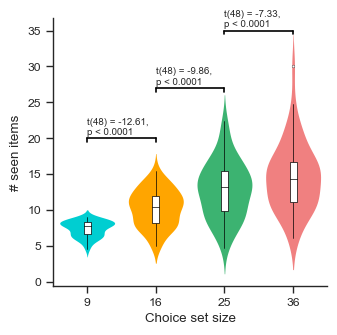

In [17]:
fig, ax = plt.subplots(1,1,figsize=cm2inch(9,9), dpi=100)
ax = violin(data=pd.DataFrame(sub_seen_items_count_means), ax=ax, palette=colors)
add_ttest(ax,
          T_seen_items_count, df_seen_items_count, P_seen_items_count,
          [(0, 1), (1, 2), (2, 3)],
          [(20, 20), (27,27), (35,35)],
          -.5, .5)
ax.set_ylabel('# seen items')
ax.set_xlabel('Choice set size')
ax.set_xticklabels(setsizes)
despine(ax=ax)

## MFX: $seen\_items\_count \sim setsize$

In [18]:
np.random.seed(166132)
mfx_filename = 'n-seen-items_setsize_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    model = bambi.Model(data=data)
    model.add('seen_items_count ~ setsize',  random=['setsize|subject'],
              categorical=['subject'])

    # sample posterior
    results = model.fit(samples=samples, 
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000,
                        random_seed=166132)

    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print('Loading mfx-summary from '+mfx_dir)
    summary = pd.read_csv( mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'setsize[0]')

Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 5.632119029781456, 94% HPD: 5.31382841197892, 5.928218003289148
setsize[0]; Mean: 0.26091487948436315, 94% HPD: 0.219470750724246, 0.2972504477101157


## .. as a fraction of choice set size

In [19]:
frac_items_seen_mean = np.concatenate(
    [np.asarray(data.groupby(['setsize','subject']).seen_items_count_fraction.mean()[s])[:,None]
     for s in setsizes], axis=1)

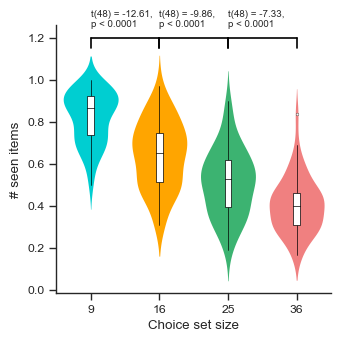

In [20]:
fig, ax = plt.subplots(1,1,figsize=cm2inch(9,9), dpi=100)
ax = violin(data=pd.DataFrame(frac_items_seen_mean), ax=ax, palette=colors)
add_ttest(ax,
          T_seen_items_count, df_seen_items_count, P_seen_items_count,
          [(0, 1), (1, 2), (2, 3)],
          [(1.2, 1.2), (1.2, 1.2), (1.2, 1.2)],
          -.05, .05)
ax.set_ylabel('# seen items')
ax.set_xlabel('Choice set size')
ax.set_xticklabels(setsizes)
despine(ax=ax)

In [21]:
np.random.seed(142112)
mfx_filename = 'frac-items-seen_setsize_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    model = bambi.Model(data=data)
    model.add('seen_items_count_fraction ~ setsize',  random=['setsize|subject'],
              categorical=['subject'])

    # sample posterior
    results = model.fit(samples=samples, 
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000,
                        random_seed=142112)

    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print('Loading mfx-summary from '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'setsize[0]')

Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.924600970623546, 94% HPD: 0.8855324292231717, 0.9647211844555308
setsize[0]; Mean: -0.015251302077085947, 94% HPD: -0.01599938109316368, -0.0145185817487729


# P(choose last seen item)

In [22]:
(last_gaze_data, 
 sub_p_last_gaze_choice_means, 
 p_last_gaze_choice_means,
 p_last_gaze_choice_sems ) = compute_p_last_gaze_choice(data,
                                                        gaze_data,
                                                        is_return_subject_means=True,
                                                        is_return_data=True)

(T_last_gaze_choice,
 df_p_last_gaze_choice,
 P_last_gaze_choice) =  compute_ttests(sub_p_last_gaze_choice_means)

/Users/thomas/projects/many-item-choice/src/utils/descriptives.py:151: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  for s in setsizes], axis=1)


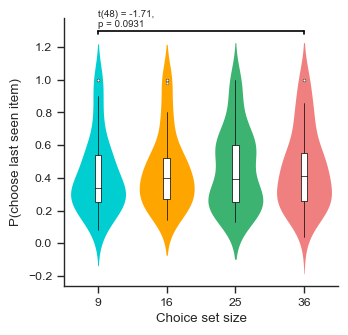

In [23]:
fig, ax = plt.subplots(1,1,figsize=cm2inch(9,9), dpi=100)
ax = violin(data=pd.DataFrame(sub_p_last_gaze_choice_means), ax=ax, palette=colors)
add_ttest(ax,
          [T_last_gaze_choice[-1]],
          df_p_last_gaze_choice,
          [P_last_gaze_choice[-1]],
          [(0, 3)],
          [(1.3, 1.3)],
          -.02, .02)
ax.set_ylabel('P(choose last seen item)')
ax.set_xlabel('Choice set size')
ax.set_xticklabels(setsizes)
despine(ax=ax)

In [24]:
print('Avg. probability of choosing the last seen item: {}'.format(np.mean(p_last_gaze_choice_means)))

Avg. probability of choosing the last seen item: 0.4456530853918962


## MFX: $P(last\_gaze\_to\_choice) \sim setsize$

In [25]:
np.random.seed(365)
mfx_filename = 'p-last-fix-choice_setsize_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    model = bambi.Model(data=last_gaze_data)
    model.add('last_gaze_to_choice ~ setsize', random=['setsize|subject'],
              categorical=['subject'])

    # sample posterior
    results = model.fit(samples=samples, 
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000,
                        random_seed=365)

    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print('Loading mfx-summary from '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'setsize[0]')

Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.4163788644279891, 94% HPD: 0.34299429887786403, 0.4804551105029498
setsize[0]; Mean: 0.0013657368936168446, 94% HPD: -1.357368994267731e-05, 0.0026183111528046373


## ..when participants don't look at all items of a choice set

In [26]:
sub_p_last_gaze_choice_not_all_seen = np.concatenate(
    [np.asarray(last_gaze_data[last_gaze_data['seen_items_count']<last_gaze_data['setsize']].groupby(
        ['setsize', 'subject']).last_gaze_to_choice.mean()[s])[:,None] for s in setsizes], axis=1)

(T_last_gaze_choice_not_all_seen,
 df_last_gaze_choice_not_all_seen,
 P_last_gaze_choice_not_all_seen) =  compute_ttests(sub_p_last_gaze_choice_not_all_seen)

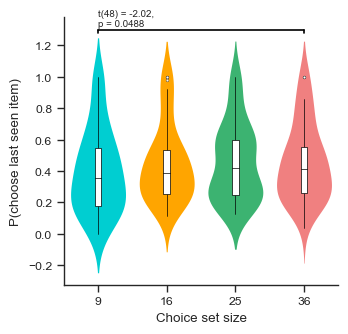

In [27]:
fig, ax = plt.subplots(1,1,figsize=cm2inch(9,9), dpi=100)
ax = violin(data=pd.DataFrame(sub_p_last_gaze_choice_not_all_seen), ax=ax, palette=colors)
add_ttest(ax,
          [T_last_gaze_choice_not_all_seen[-1]],
          df_last_gaze_choice_not_all_seen,
          [P_last_gaze_choice_not_all_seen[-1]],
          [(0, 3)],
          [(1.3, 1.3)],
          -.02, .02)
ax.set_ylabel('P(choose last seen item)')
ax.set_xlabel('Choice set size')
ax.set_xticklabels(setsizes)
despine(ax=ax)

In [28]:
means_p_last_gaze_choice_not_all_seen = last_gaze_data[
    last_gaze_data['seen_items_count']<last_gaze_data['setsize']].groupby(
    ['setsize', 'subject']).last_gaze_to_choice.mean().groupby(level=0).mean()
print('Avg. probability of choosing the last seen item: {}'.format(np.mean(means_p_last_gaze_choice_not_all_seen)))

Avg. probability of choosing the last seen item: 0.4413194373899568


## MFX: $P(last\_gaze\_to\_choice) \sim setsize$ 

In [29]:
np.random.seed(58745)
mfx_filename = 'p-last-fix-choice-when-not-all-seen_setsize_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    model = bambi.Model(data=last_gaze_data[last_gaze_data['seen_items_count']<
                                            last_gaze_data['setsize']].copy())
    model.add('last_gaze_to_choice ~ setsize', random=['setsize|subject'], 
              categorical=['subject'])

    # sample posterior
    results = model.fit(samples=samples, 
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000,
                        random_seed=58745)

    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print('Loading mfx-summary from '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'setsize[0]')

Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.4223682926721905, 94% HPD: 0.3519244431856446, 0.4965585704068978
setsize[0]; Mean: 0.001247431707855298, 94% HPD: -0.00032693803363172363, 0.002625489844523641


## MFX: $P(current\_gaze\_is\_last) \sim cached\_value + time + setsize$

In [30]:
np.random.seed(6532)
mfx_filename = 'p-is-last-fix_cached-value-time_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):

    # load gaze data
    gaze_data_tmp = []
    for subject in subjects:
        # load subject data
        subject_data = data[data['subject']==subject].copy()
        subject_gaze_data = gaze_data[gaze_data['subject']==subject].copy()
        cached_value = []
        cumulative_time = []
        for trial in subject_gaze_data.trial.unique():
            trial_gaze_data = subject_gaze_data[subject_gaze_data['trial']==trial].copy()
            trial_cached_value = np.maximum.accumulate(trial_gaze_data['value'].values)
            cached_value.append(trial_cached_value)
            trial_cumulative_time = np.cumsum(trial_gaze_data['dur'])
            cumulative_time.append(trial_cumulative_time)
        subject_gaze_data['cached_value'] = np.concatenate(cached_value).astype('float64')
        subject_gaze_data['cumulative_time'] = np.concatenate(cumulative_time).astype('float64')
        gaze_data_tmp.append(subject_gaze_data)
    gaze_data_tmp = pd.concat(gaze_data_tmp, sort=True)
    gaze_data_tmp.reset_index(drop=True, inplace=True)

    # make model
    samples = 2000
    burn = 500
    model = bambi.Model(data=gaze_data_tmp)

    # fixed effects
    model.add('is_last ~ cached_value + cumulative_time + setsize',
              categorical=['subject'])

    # random effects
    model.add(random=['1|subject'])
    model.add(random=['0+setsize|subject'])
    model.add(random=['0+cached_value|subject'])
    model.add(random=['0+cumulative_time|subject'])

    # sample posterior
    results = model.fit(samples=samples, 
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000,
                        random_seed=6532)

    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print('Loading mfx-summary from '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'cached_value[0]')
_ = get_var(summary, 'cumulative_time[0]')
_ = get_var(summary, 'setsize[0]')

Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.02172374863213656, 94% HPD: 0.015254710835992747, 0.028350066692895824
cached_value[0]; Mean: 0.026714367220029712, 94% HPD: 0.020487560959620853, 0.032842435313960375
cumulative_time[0]; Mean: 2.261978314163816e-05, 94% HPD: 1.6908006313800006e-05, 2.803711694896359e-05
setsize[0]; Mean: -0.002229159023236356, 94% HPD: -0.002416883429320555, -0.002021983029034647


# Gaze influence on P(choose item)

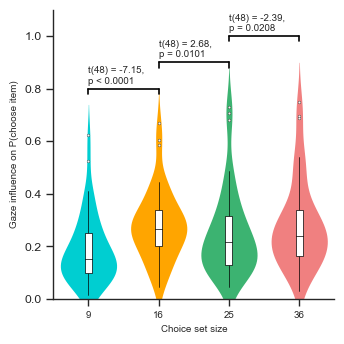

In [31]:
sub_gaze_influence_scores = []
for setsize in setsizes:
    sub_gaze_influence_scores.append(
        compute_gaze_influence_score(data[data['setsize']==setsize].copy())[:,None])
sub_gaze_influence_scores = pd.DataFrame(np.concatenate(sub_gaze_influence_scores, axis=1))

(T_gaze_influence_score,
 df_gaze_influence_score,
 P_gaze_influence_score) =  compute_ttests(sub_gaze_influence_scores.values)

fig, ax = plt.subplots(1,1,figsize=cm2inch(9,9), dpi=100)
ax = violin(data=sub_gaze_influence_scores, ax=ax, palette=colors)
add_ttest(ax,
          T_gaze_influence_score,
          df_gaze_influence_score,
          P_gaze_influence_score,
          [(0, 1), (1, 2), (2, 3)],
          [(0.8, 0.8), (0.9, 0.9), (1, 1)],
          -.02, .02)
ax.set_ylim(0, 1.1)
ax.set_ylabel('Gaze influence on P(choose item)', fontsize=7)
ax.set_xlabel('Choice set size', fontsize=7)
ax.set_xticks(np.arange(4))
ax.set_xticklabels([9,16,25,36], fontsize=7)
ax = despine(ax=ax)
fig.tight_layout()

## MFX: $gaze\_influence \sim setsize$

In [32]:
np.random.seed(38192)
mfx_filename = 'gaze-influence_setsize_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # collect scores
    mfx_df = []
    for setsize in setsizes:
        setsize_scores = compute_gaze_influence_score(data[data['setsize']==setsize].copy())
        df_tmp = pd.DataFrame({'gaze_influence': setsize_scores,
                               'setsize': setsize,
                               'subject': np.arange(49)})
        mfx_df.append(df_tmp)
    mfx_df = pd.concat(mfx_df)
    
    # make model
    samples = 2000
    burn = 500
    model = bambi.Model(data=mfx_df)
    model.add('gaze_influence ~ setsize', random=['setsize|subject'], 
              categorical=['subject'])

    # sample posterior
    results = model.fit(samples=samples, 
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000,
                        random_seed=38192)

    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print('Loading mfx-summary from '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'setsize[0]')

Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.19155085442793354, 94% HPD: 0.15264032018318996, 0.2314303825841681
setsize[0]; Mean: 0.0026367614685309762, 94% HPD: 0.001490499263907034, 0.003941752488429872


## MFX: $P(choose\_item) \sim gaze\_advantage + relative\_rating + value\_range\_others + setsize$

In [33]:
# get gaze data
gaze_influence_df = []
for setsize in setsizes:
    # subset
    data_setsize = data[data['setsize']==setsize].copy()
    # index choice
    choice = np.zeros((data_setsize.shape[0], setsize))
    choice[np.arange(data_setsize.shape[0]), data_setsize['choice'].values.astype('int32')] = 1
    # get data
    gaze = data_setsize[['gaze_{}'.format(i) for i in range(setsize)]].values
    values = data_setsize[['item_value_{}'.format(i) for i in range(setsize)]].values
    gaze_advantage = np.zeros_like(values)
    rel_values = np.zeros_like(values)
    value_range = np.zeros_like(values)
    for t in range(values.shape[0]):
        for i in range(setsize):
            index = np.arange(setsize)!=i
            gaze_advantage[t,i] = gaze[t,i] - np.max(gaze[t, index])
            rel_values[t,i] = values[t,i] - np.mean(values[t, index])
            value_range[t, i] = (np.max(values[t, index]) - np.min(values[t, index]))
    # collect
    df_tmp = pd.DataFrame(dict(subject=np.repeat(data_setsize['subject'].values, setsize),
                               setsize=setsize,
                               is_choice=choice.ravel(),
                               value=values.ravel(),
                               rel_value=rel_values.ravel(),
                               value_range_others=value_range.ravel(),
                               rel_gaze=gaze_advantage.ravel(),
                               gaze=gaze.ravel()))
    gaze_influence_df.append(df_tmp)
gaze_influence_df = pd.concat(gaze_influence_df)

In [34]:
np.random.seed(84123)
mfx_filename = 'p-choice_relative-rating-and-range_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    samples = 2000
    burn = 500
    gaze_influence_df['rel_gaze'] = gaze_influence_df['rel_gaze'] * 100
    model = bambi.Model(data=gaze_influence_df)
    model.add('is_choice ~ rel_gaze + rel_value + value_range_others + setsize',
                               random=['1|subject',
                                       '0+setsize|subject',
                                       '0+rel_gaze|subject',
                                       '0+rel_value|subject',
                                       '0+value_range_others|subject'],
                               categorical=['subject'])

    # sapmle posterior
    results = model.fit(samples=samples,
                        tune=burn,
                        chains=2,
                        family='bernoulli',
                        backend='pymc',
                        init='ADVI',
                        n_init=50000,
                        random_seed=84123)

    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print('Loading mfx-summary from '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'rel_gaze[0]')
_ = get_var(summary, 'rel_value[0]')
_ = get_var(summary, 'value_range_others[0]')
_ = get_var(summary, 'setsize[0]')

Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.2979436923418969, 94% HPD: 0.27745025548065305, 0.3190009728681377
rel_gaze[0]; Mean: 0.004586160930335409, 94% HPD: 0.003973114472133895, 0.005236689603052982
rel_value[0]; Mean: 0.03639788974048213, 94% HPD: 0.032303966402904116, 0.040049144831917335
value_range_others[0]; Mean: -0.027772304363575823, 94% HPD: -0.031439128811815764, -0.023811526957106872
setsize[0]; Mean: -0.001587776534078616, 94% HPD: -0.0017782504515327536, -0.0013946719551829162


# Figure 4

In [35]:
def compute_associations_figure_4F(data, gaze_data, setsizes=np.array([9,16,25,36]), verbose=False):
    """Compute Spearman rank correlations for associations  
    shown in Fig. 4 F of the manuscript. 
    
    Args:
        data (dataframe): choice data   
        gaze_data (dataframe): gaze data
        setsizes (array of int): choice set size conditions
        verbose (bool): whether to print results of each
            association test
                
    Returns:
        matrix with correlation coefficients and p-values:
        (var A x var B x (correlation coefficient, p-value))
    """
    
    # 1. Seen items count vs set-size
    data['frac_items_seen'] = (data['seen_items_count'] / data['setsize']).values.astype(np.float)
    sub_frac_items_seen = np.concatenate(
        [data.groupby(['setsize', 'subject']).frac_items_seen.mean()[s][:,None] for s in setsizes],
        axis=1)
    
    # 2. Response time vs set-size
    sub_rt_means = np.concatenate(
        [data.groupby(['setsize', 'subject']).rt_s.mean()[s][:,None] for s in setsizes],
        axis=1)
    
    # 3. P(choose best seen item )
    sub_best_seen_chosen_means = np.concatenate(
        [data.groupby(['setsize','subject']).best_seen_chosen.mean()[s][:,None] for s in setsizes],
        axis=1)
    
    # 4. P(last gaze to choice)
    (sub_p_last_fix_choice_means,
     p_last_fix_choice_means,
     p_last_fix_choice_sems) = compute_p_last_gaze_choice(data, gaze_data)
    
    # 5. Gaze Influence on choice probability
    sub_gaze_influence_scores = []
    for setsize in setsizes:
        sub_gaze_influence_scores.append(compute_gaze_influence_score(data[data['setsize']==setsize].copy()))
    sub_gaze_influence_scores = np.concatenate([s[:,None] for s in sub_gaze_influence_scores],
                                               axis=1)
    
    # Make df (average over setsizes)
    assoc_df = pd.DataFrame({'subject': subjects,
                             'frac_items_seen': sub_frac_items_seen.mean(axis=1),
                             'RT': sub_rt_means.mean(axis=1),
                             'best_chosen': sub_best_seen_chosen_means.mean(axis=1),
                             'last_gaze_to_choice': sub_p_last_fix_choice_means.mean(axis=1),
                             'gaze_influence': sub_gaze_influence_scores.mean(axis=1)})
    
    # Define combinations
    xs = ['best_chosen', 'best_chosen', 'best_chosen', 'best_chosen', 'best_chosen',
          'frac_items_seen', 'frac_items_seen', 'frac_items_seen', 'frac_items_seen',
          'RT', 'RT', 'RT',
          'last_gaze_to_choice', 'last_gaze_to_choice',
          'gaze_influence']
    ys = ['best_chosen', 'frac_items_seen', 'RT', 'last_gaze_to_choice', 'gaze_influence',
          'frac_items_seen', 'RT', 'last_gaze_to_choice', 'gaze_influence',
          'RT', 'last_gaze_to_choice', 'gaze_influence',
          'last_gaze_to_choice', 'gaze_influence',
          'gaze_influence']
    pos = [(0,0), (1,0), (2,0), (3,0), (4,0),
           (1,1), (2,1), (3,1), (4,1),
           (2,2), (3,2), (4,2),
           (3,3), (4,3),
           (4,4)]
    
    if verbose:
        print('\nCorrelation coefficients:')
    
    # Compute correlations
    association_mat = np.zeros((5,5,2)) * np.nan
    for x, y, (xi, yi) in zip(xs, ys, pos):
        if verbose:
            print('\n{} ~ {}'.format(x,y))
        r, p = spearmanr(assoc_df[x], assoc_df[y])
        if verbose:
            print('Spearman r = {}, p = {}'.format(r, p))
        association_mat[xi, yi] = r, p
    
    return association_mat

In [36]:
def figure_4(data, gaze_data, colors=['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral']):
    """Create figure 4 of the manuscript.
    
    Args:
        data (dataframe): choice data   
        gaze_data (dataframe): gaze data
        colors (array of strings): colors to use for set sizes
                
    Returns:
        matplotlib figure / axis
    """
    
    # create figure
    fig, axs = plt.subplots(2, 3, figsize=cm2inch(16,10), dpi=300)
    axs = axs.ravel()
        
    # extract subject count
    n_subjects = data.subject.unique().size
    
    
    # 1. P(choose best seen item )
    sub_best_seen_chosen_means = np.concatenate(
        [np.asarray(data.groupby(['setsize','subject']).best_seen_chosen.mean()[s])[:,None]
         for s in setsizes], axis=1)
    axs[0] = violin(data=pd.DataFrame(sub_best_seen_chosen_means), ax=axs[0], palette=colors)
    axs[0].set_ylim(0, 1)
    axs[0].set_ylabel('P(best seen item chosen)', fontsize=7)
    axs[0].set_xlabel('Choice set size', fontsize=7)
    axs[0].set_xticks(np.arange(4))
    axs[0].set_xticklabels([9,16,25,36], fontsize=7)
    axs[0] = despine(ax=axs[0])
    
    
    # 1. % items seen vs set-size
    frac_items_seen_means = np.concatenate(
        [np.asarray(data.groupby(['setsize','subject']).seen_items_count_fraction.mean()[s])[:,None]
         for s in setsizes], axis=1)
    axs[1] = violin(data=pd.DataFrame(frac_items_seen_means), ax=axs[1], palette=colors)
    axs[1].set_ylim(0,1)
    axs[1].set_ylabel('% of items seen', fontsize=7)
    axs[1].set_xlabel('Choice set size', fontsize=7)
    axs[1].set_xticks(np.arange(4))
    axs[1].set_xticklabels([9,16,25,36], fontsize=7)
    despine(ax=axs[1])
    
    
    # 2. Response time vs set-size
    sub_rt_means = np.concatenate(
        [np.asarray(data.groupby(['setsize','subject']).rt_s.mean()[s])[:,None]
         for s in setsizes], axis=1)
    axs[2] = violin(data=pd.DataFrame(sub_rt_means), ax=axs[2], palette=colors)
    axs[2].set_ylabel('Mean RT (s)', fontsize=7)
    axs[2].set_xlabel('Choice set size', fontsize=7)
    axs[2].set_xticks(np.arange(4))
    axs[2].set_xticklabels([9,16,25,36], fontsize=7)
    axs[2].set_ylim(0,15)
    axs[2].set_yticks([0,5,10,15])
    axs[2] = despine(ax=axs[2])
    
    
    # 4. P(last gaze to choice)
    # load gaze data
    (sub_p_last_fix_choice_means, _, _) = compute_p_last_gaze_choice(data, gaze_data)
    axs[3] = violin(data=pd.DataFrame(sub_p_last_fix_choice_means), ax=axs[3], palette=colors)
    axs[3].set_ylim(0, 1)
    axs[3].set_ylabel('P(last seen item chosen)', fontsize=7)
    axs[3].set_xlabel('Choice set size', fontsize=7)
    axs[3].set_xticks(np.arange(4))
    axs[3].set_xticklabels([9,16,25,36], fontsize=7)
    axs[3] = despine(ax=axs[3])
    
    
    # 5. Gaze Influence Score
    sub_gaze_influence_scores = []
    for setsize in setsizes:
        sub_gaze_influence_scores.append(
            compute_gaze_influence_score(data[data['setsize']==setsize].copy())[:,None])
    axs[4] = violin(data=pd.DataFrame(np.concatenate(sub_gaze_influence_scores, axis=1)), ax=axs[4], palette=colors)
    axs[4].set_ylim(0, 1)
    axs[4].set_ylabel('Gaze influence\non P(choose item)', fontsize=7)
    axs[4].set_xlabel('Choice set size', fontsize=7)
    axs[4].set_xticks(np.arange(4))
    axs[4].set_xticklabels([9,16,25,36], fontsize=7)
    axs[4] = despine(ax=axs[4])
    
    
    # association matrix
    axs[5].set_title('Spearman rank correlation \nof behavioural metrics', fontsize=7)
    assoc_mat = compute_associations_figure_4F(data, gaze_data, setsizes=np.array([9,16,25,36]), verbose=True)
    im = axs[5].imshow(assoc_mat[:,:,0], cmap='viridis', vmax=1, vmin=-0.3)
    despine(ax=axs[5])
    axs[5].set_xticks(np.arange(5))
    axs[5].set_yticks(np.arange(5))
    axs[5].set_xticklabels(['A', 'B', 'C', 'D', 'E'], fontsize=7)
    axs[5].set_yticklabels(['A', 'B', 'C', 'D', 'E'], fontsize=7)
    axs[5].set_ylim(4.5, -0.5)
    axs[5].set_xlim(-0.5, 4.5)
    # label
    pos = [(0,0), (1,0), (2,0), (3,0), (4,0),
           (1,1), (2,1), (3,1), (4,1),
           (2,2), (3,2), (4,2),
           (3,3), (4,3),
           (4,4)]
    thresh = 0.4
    for (i, j) in pos:
        if assoc_mat[i, j, 1] < (0.1 / 10.) and i!=j:
            axs[5].text(j, i, "{:1.2f}".format(assoc_mat[i, j, 0]),
                        horizontalalignment="center",
                        color="white" if assoc_mat[i, j, 0] < thresh else "black",
                        fontsize=6, fontweight='bold')
        else:
            axs[5].text(j, i, "{:1.2f}".format(assoc_mat[i, j, 0]),
                    horizontalalignment="center",
                    color="white" if assoc_mat[i, j, 0] < thresh else "black",
                    fontsize=6)
        
    
    # index axes
    for label, ax in zip(list('ABCDEF'), axs):
        ax.text(-0.35, 1.15, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')
    for ax in axs[:5]:
        ax.tick_params(axis='both', which='major', labelsize=7)
    
    fig.tight_layout(h_pad=1)
    
    return fig, axs

/Users/thomas/projects/many-item-choice/src/utils/descriptives.py:151: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  for s in setsizes], axis=1)
/opt/miniconda3/envs/GLAM/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/miniconda3/envs/GLAM/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/miniconda3/envs/GLAM/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in 


Correlation coefficients:

best_chosen ~ best_chosen
Spearman r = 0.9999999999999999, p = 0.0

best_chosen ~ frac_items_seen
Spearman r = -0.15071428571428572, p = 0.3012839002824282

best_chosen ~ RT
Spearman r = -0.1646938775510204, p = 0.2581230306467912

best_chosen ~ last_gaze_to_choice
Spearman r = -0.13989795918367345, p = 0.33769432575057523

best_chosen ~ gaze_influence
Spearman r = -0.36612244897959184, p = 0.009675567275816413

frac_items_seen ~ frac_items_seen
Spearman r = 0.9999999999999999, p = 0.0

frac_items_seen ~ RT
Spearman r = 0.9177551020408162, p = 1.7779076759637664e-20

frac_items_seen ~ last_gaze_to_choice
Spearman r = -0.00520408163265306, p = 0.9716903186367563

frac_items_seen ~ gaze_influence
Spearman r = -0.017755102040816324, p = 0.9036223528652839

RT ~ RT
Spearman r = 0.9999999999999999, p = 0.0

RT ~ last_gaze_to_choice
Spearman r = -0.0032653061224489793, p = 0.9822348752243806

RT ~ gaze_influence
Spearman r = 0.033571428571428565, p = 0.81887055141

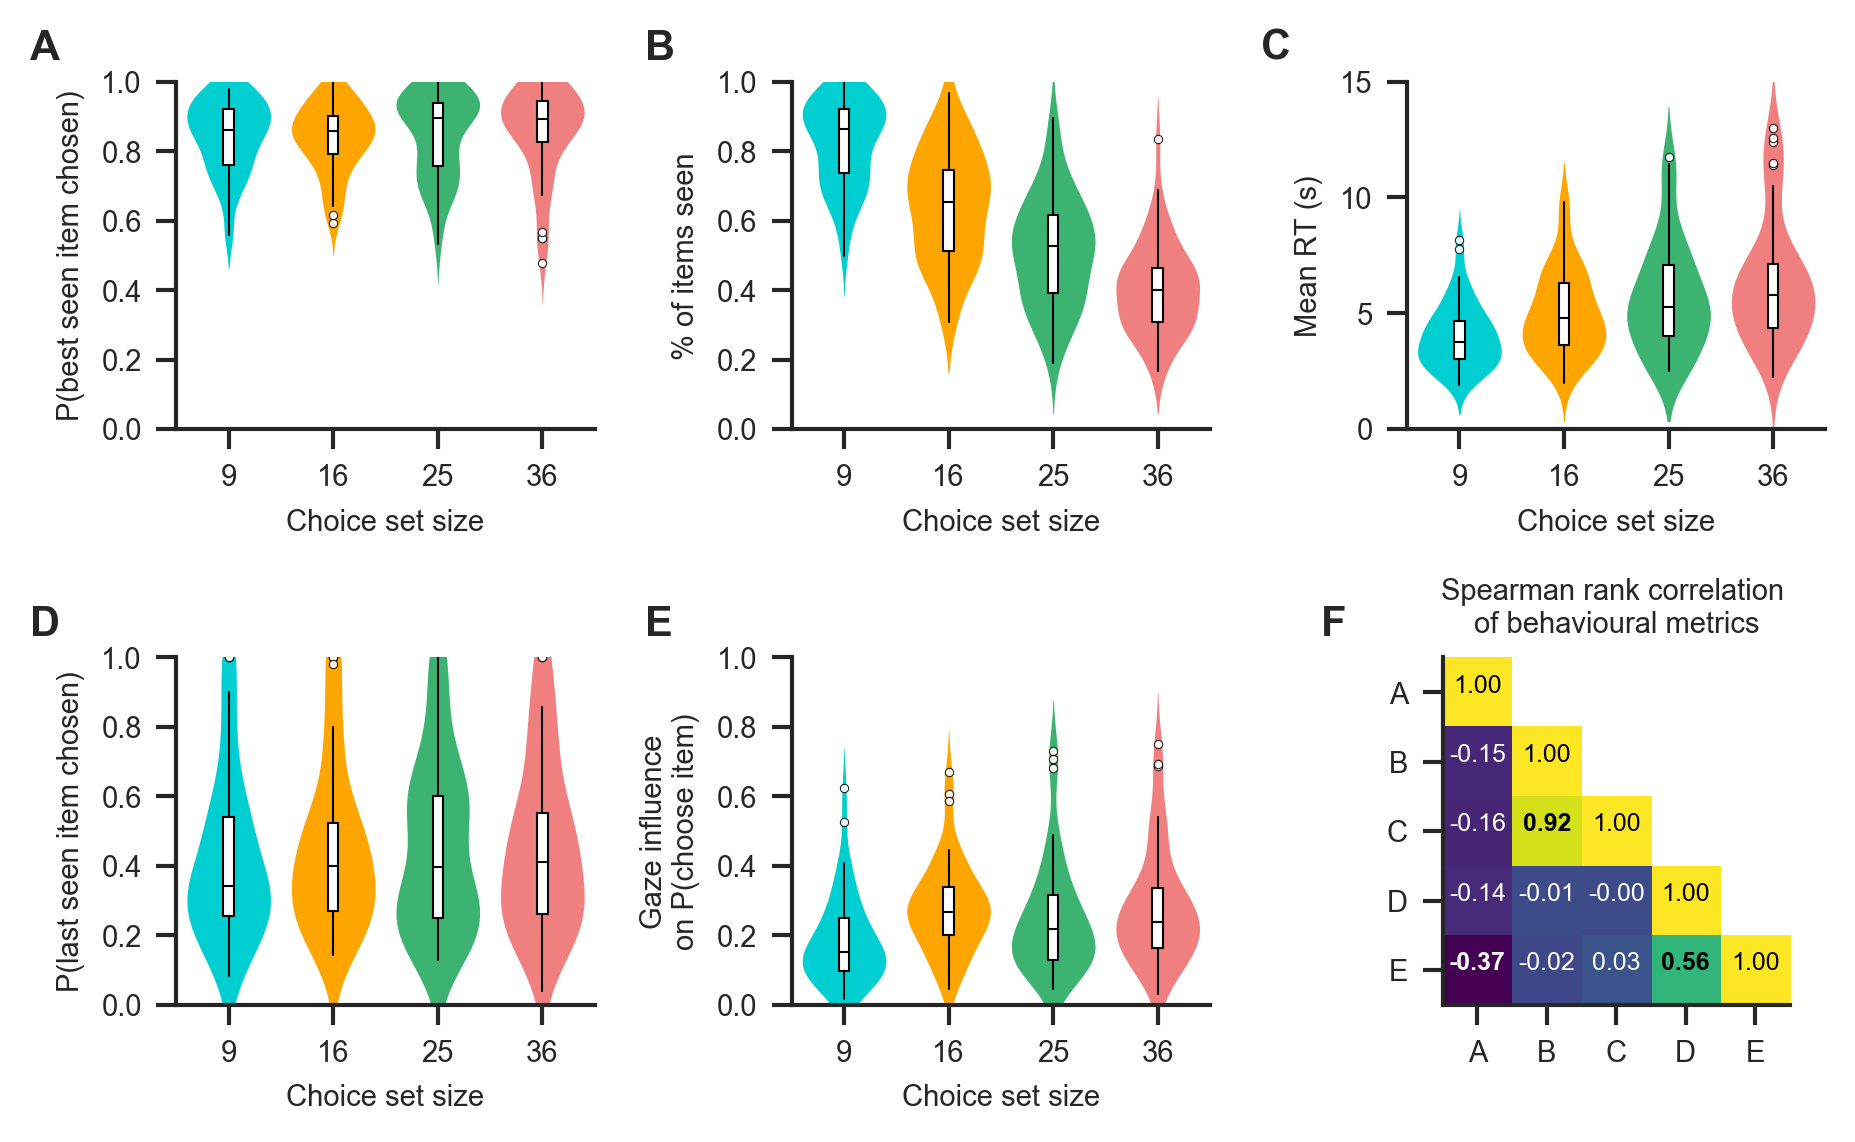

In [37]:
np.random.seed(10)

fig, _ = figure_4(data, gaze_data)
fig.savefig(figure_dir+'Figure-4_choice-psychometrics.pdf', dpi=300)
fig.savefig(figure_dir+'Figure-4_choice-psychometrics.png', dpi=300)
fig.savefig(figure_dir+'Figure-4_choice-psychometrics.jpg', dpi=300)

## Three additional tests of the gaze bias hypothesis: 

### 1.  MFX: $P(best\_seen\_item\_chosen) \sim gaze\_influence$ & 
### 2.  MFX: $P(last\_seen\_item\_chosen) \sim gaze\_influence$

In [38]:
# aggregate response measures:

# 1. P(choose best seen item )
sub_best_seen_chosen_means = np.concatenate([
    np.array(data.groupby(['setsize','subject']).best_seen_chosen.mean()[s])[:,None]
    for s in setsizes], axis=1)
    
# 2. P(last gaze to choice)
(sub_p_last_fix_choice_means,
 p_last_fix_choice_means,
 p_last_fix_choice_sems) = compute_p_last_gaze_choice(data, gaze_data)
    
# 3. Gaze Influence on choice probability
sub_gaze_influence_scores = []
for setsize in setsizes:
    sub_gaze_influence_scores.append(compute_gaze_influence_score(data[data['setsize']==setsize].copy()))

/Users/thomas/projects/many-item-choice/src/utils/descriptives.py:151: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  for s in setsizes], axis=1)


In [39]:
# create df for mfx regression

mfx_df = []
for si, setsize in enumerate(setsizes):
    df_tmp = pd.DataFrame({'subject': subjects,
                           'setsize': setsize,
                           'best_chosen': sub_best_seen_chosen_means[:,si]*100,
                           'last_gaze_to_choice': sub_p_last_fix_choice_means[:,si]*100,
                           'gaze_influence': sub_gaze_influence_scores[si]*100})
    mfx_df.append(df_tmp)
mfx_df = pd.concat(mfx_df)

In [40]:
# estimate mfx models:

seed = 4121

for x, y in zip(['gaze_influence', 'gaze_influence'],
                ['best_chosen', 'last_gaze_to_choice']):
    
    print('\n\nComputing: {} ~ {}'.format(y, x))
    
    mfx_filename = '{}_{}_mfx'.format('-'.join(y.split('_')), '-'.join(x.split('_')))
    if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
            
        # make model
        samples = 2000
        burn = 500
        model = bambi.Model(data=mfx_df)
        model.add('{} ~ {}'.format(y, x),
                  random=['1|setsize','0+{}|setsize'.format(x)],
                  categorical=['setsize'])

        # sample posterior
        results = model.fit(samples=samples,
                            tune=burn,
                            chains=2,
                            backend='pymc',
                            init='ADVI',
                            n_init=50000,
                            random_seed=seed)

        # save results
        pm.trace_to_dataframe(model.backend.trace).to_csv(
            mfx_dir+mfx_filename+'_mtrace.csv', index=False)
        az.plot_trace(results)
        plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
        summary = az.summary(results, round_to='none')
        summary.to_csv(mfx_dir+mfx_filename+'.csv')

    else:
        print('Loading mfx-summary from '+mfx_dir)
        summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

    _ = get_var(summary, 'Intercept[0]')
    _ = get_var(summary, '{}[0]'.format(x))
    
    seed += 1



Computing: best_chosen ~ gaze_influence
Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 89.9042406203782, 94% HPD: 86.4155827482559, 93.11473325187642
gaze_influence[0]; Mean: -0.21964009867884773, 94% HPD: -0.35630963944673405, -0.08387558317717361


Computing: last_gaze_to_choice ~ gaze_influence
Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 17.524358102686932, 94% HPD: 9.806543250452508, 24.710549689222173
gaze_influence[0]; Mean: 1.0966744293682746, 94% HPD: 0.8743681897553279, 1.3141771092555925


### 3.  MFX: $P(choose\_first\_seen) \sim dur(first\_gaze) + value + setsize$

In [41]:
np.random.seed(574135)
mfx_filename = 'p-choose-first-seen_dur-first-gaze_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # compute gaze times per item
    first_gaze_data = gaze_data[gaze_data['fixnum']==1].copy()
    is_choice = (first_gaze_data['item']==first_gaze_data['choice']).astype(np.int)
    df_tmp = pd.DataFrame(dict(is_choice=is_choice,
                               first_gaze_dur=first_gaze_data['dur'].astype(np.int),
                               value=first_gaze_data['value'],
                               setsize=first_gaze_data['setsize'],
                               subject=first_gaze_data['subject']))
    
    # make model
    samples = 2000
    burn = 500
    model = bambi.Model(data=df_tmp)
    model.add('is_choice ~ first_gaze_dur + value + setsize',
              random=['1|subject',
                      '0+first_gaze_dur|subject',
                      '0+value|subject',
                      '0+setsize|subject'],
              categorical=['subject'])

    # sample posterior
    results = model.fit(samples=samples,
                        tune=burn,
                        chains=2,
                        family='bernoulli',
                        backend='pymc',
                        init='ADVI',
                        n_init=50000,
                        random_seed=574135)

    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print('Loading mfx-summary from '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'first_gaze_dur[0]')
_ = get_var(summary, 'value[0]')
_ = get_var(summary, 'setsize[0]')

Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 0.07201901331085205, 94% HPD: 0.05168522805338442, 0.09011498742104693
first_gaze_dur[0]; Mean: 0.00017818842689314423, 94% HPD: 0.0001372017357860861, 0.0002221429215583116
value[0]; Mean: 0.06004897294358232, 94% HPD: 0.05454845634812575, 0.06582913110421479
setsize[0]; Mean: -0.0027104565398859285, 94% HPD: -0.003216646989714988, -0.0021678664366557828
